# Eye Health Prediction: A Machine Learning Approach
link https://www.kaggle.com/datasets/jockeroika/eye-health/data?select=patient_data.csv


## Introduction

This notebook explores a dataset focused on eye health, aiming to predict the presence of 'has_eye_disease' based on various patient-specific features. The dataset contains a mix of demographic, health, and metabolic indicators, including age, sugar percentage, glucose percentage, cholesterol percentage, obesity, blood pressure, heart rate, and metabolic risk factors. The primary objective is to build and evaluate classification models to accurately identify individuals with eye disease.

### Workflow:
1.  **Data Loading and Exploration**: Load the dataset, inspect its structure, check for missing values, and understand basic statistics.
2.  **Data Preprocessing**: Handle categorical variables through one-hot encoding and scale numerical features to prepare the data for machine learning algorithms.
3.  **Exploratory Data Analysis (EDA)**: Visualize data distributions, correlations, and potential outliers to gain insights into the dataset.
4.  **Model Training and Evaluation**: Implement and evaluate several classification models, including Logistic Regression, RandomForestClassifier, GradientBoostingClassifier, Support Vector Classifier (SVC), XGBoost, Voting Classifier, Stacking Classifier, and a Neural Network. Each model's performance will be assessed using accuracy, precision, recall, F1-score, and ROC AUC.
5.  **Feature Importance Analysis**: Identify the most influential features for predicting eye disease.
6.  **Neural Network Overfitting Analysis**: Visualize the training and validation loss/accuracy curves to understand and mitigate overfitting using techniques like Dropout and EarlyStopping.
7.  **Conclusion**: Summarize the performance of all models, highlight the best-performing approach, and discuss potential next steps for further improvement.

## Imports

In [1]:
import pandas as pd
import os
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Load The Data

In [3]:
# Download latest version
path = kagglehub.dataset_download("jockeroika/eye-health")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'eye-health' dataset.
Path to dataset files: /kaggle/input/eye-health


In [4]:
print(os.listdir(path))

['patient_data.csv', 'processed_dataset.csv']


In [5]:
df = pd.read_csv(os.path.join(path,'processed_dataset.csv'))

## Explore The Data

In [6]:
df.head()

,Unnamed: 0,name,age,has_eye_disease,has_diabetic_retinopathy,sugar_percentage,glucose_percentage,cholesterol_percentage,obesity_percentage,blood_pressure,heart_rate,systolic,diastolic,bp_category,obesity_group,metabolic_risk_count,metabolic_syndrome_flag,health_risk_score
0,0,Patient 1,39,False,False,5.70,147.48,164.45,32.94,122/63,94,122,63,elevated,obese,2,True,48.002569
1,1,Patient 2,67,True,False,8.72,91.52,235.62,39.58,92/80,68,92,80,stage_1,obese,2,True,44.561545
2,2,Patient 3,44,True,False,13.83,160.17,299.13,38.45,140/60,67,140,60,stage_2,obese,4,True,73.000519
3,3,Patient 4,46,True,True,9.48,106.84,236.75,29.10,132/83,82,132,83,stage_1,overweight,2,True,61.675717
4,4,Patient 5,39,False,False,5.60,158.65,182.11,16.25,128/72,63,128,72,elevated,underweight,1,False,34.566440


In [7]:
df.isna().sum().sum()

np.int64(0)

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.shape

(20000, 18)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                20000 non-null  int64  
 1   name                      20000 non-null  object 
 2   age                       20000 non-null  int64  
 3   has_eye_disease           20000 non-null  bool   
 4   has_diabetic_retinopathy  20000 non-null  bool   
 5   sugar_percentage          20000 non-null  float64
 6   glucose_percentage        20000 non-null  float64
 7   cholesterol_percentage    20000 non-null  float64
 8   obesity_percentage        20000 non-null  float64
 9   blood_pressure            20000 non-null  object 
 10  heart_rate                20000 non-null  int64  
 11  systolic                  20000 non-null  int64  
 12  diastolic                 20000 non-null  int64  
 13  bp_category               20000 non-null  object 
 14  obesit

## Preprocessing

In [11]:
df = df.drop(columns=['Unnamed: 0','name'])

In [12]:
# convert the boolean columns to integers. Works for any kind of data
bool_cols = df.select_dtypes(include='bool').columns
for col in bool_cols:
    df[col] = df[col].astype(int)

df.head()

,age,has_eye_disease,has_diabetic_retinopathy,sugar_percentage,glucose_percentage,cholesterol_percentage,obesity_percentage,blood_pressure,heart_rate,systolic,diastolic,bp_category,obesity_group,metabolic_risk_count,metabolic_syndrome_flag,health_risk_score
0,39,0,0,5.70,147.48,164.45,32.94,122/63,94,122,63,elevated,obese,2,1,48.002569
1,67,1,0,8.72,91.52,235.62,39.58,92/80,68,92,80,stage_1,obese,2,1,44.561545
2,44,1,0,13.83,160.17,299.13,38.45,140/60,67,140,60,stage_2,obese,4,1,73.000519
3,46,1,1,9.48,106.84,236.75,29.10,132/83,82,132,83,stage_1,overweight,2,1,61.675717
4,39,0,0,5.60,158.65,182.11,16.25,128/72,63,128,72,elevated,underweight,1,0,34.566440


In [13]:
df['blood_pressure'].unique()

array(['122/63', '92/80', '140/60', ..., '106/69', '107/89', '125/61'],
      dtype=object)

In [14]:
# Drop the 'blood_pressure' column as it's a string and its numerical components (systolic, diastolic) are already separate features.
df = df.drop('blood_pressure', axis=1)


In [15]:
df['bp_category'].unique()

array(['elevated', 'stage_1', 'stage_2', 'normal'], dtype=object)

In [16]:
df['obesity_group'].unique()

array(['obese', 'overweight', 'underweight', 'normal'], dtype=object)

In [17]:
cols = ['obesity_group','bp_category']

dummy = pd.get_dummies(df[cols]).astype(int)
df = pd.concat([df,dummy],axis=1)
df = df.drop(columns=cols)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        20000 non-null  int64  
 1   has_eye_disease            20000 non-null  int64  
 2   has_diabetic_retinopathy   20000 non-null  int64  
 3   sugar_percentage           20000 non-null  float64
 4   glucose_percentage         20000 non-null  float64
 5   cholesterol_percentage     20000 non-null  float64
 6   obesity_percentage         20000 non-null  float64
 7   heart_rate                 20000 non-null  int64  
 8   systolic                   20000 non-null  int64  
 9   diastolic                  20000 non-null  int64  
 10  metabolic_risk_count       20000 non-null  int64  
 11  metabolic_syndrome_flag    20000 non-null  int64  
 12  health_risk_score          20000 non-null  float64
 13  obesity_group_normal       20000 non-null  int

In [19]:
df.isna().sum()

,0
age,0
has_eye_disease,0
has_diabetic_retinopathy,0
sugar_percentage,0
glucose_percentage,0
cholesterol_percentage,0
obesity_percentage,0
heart_rate,0
systolic,0
diastolic,0


## Visualize The Data

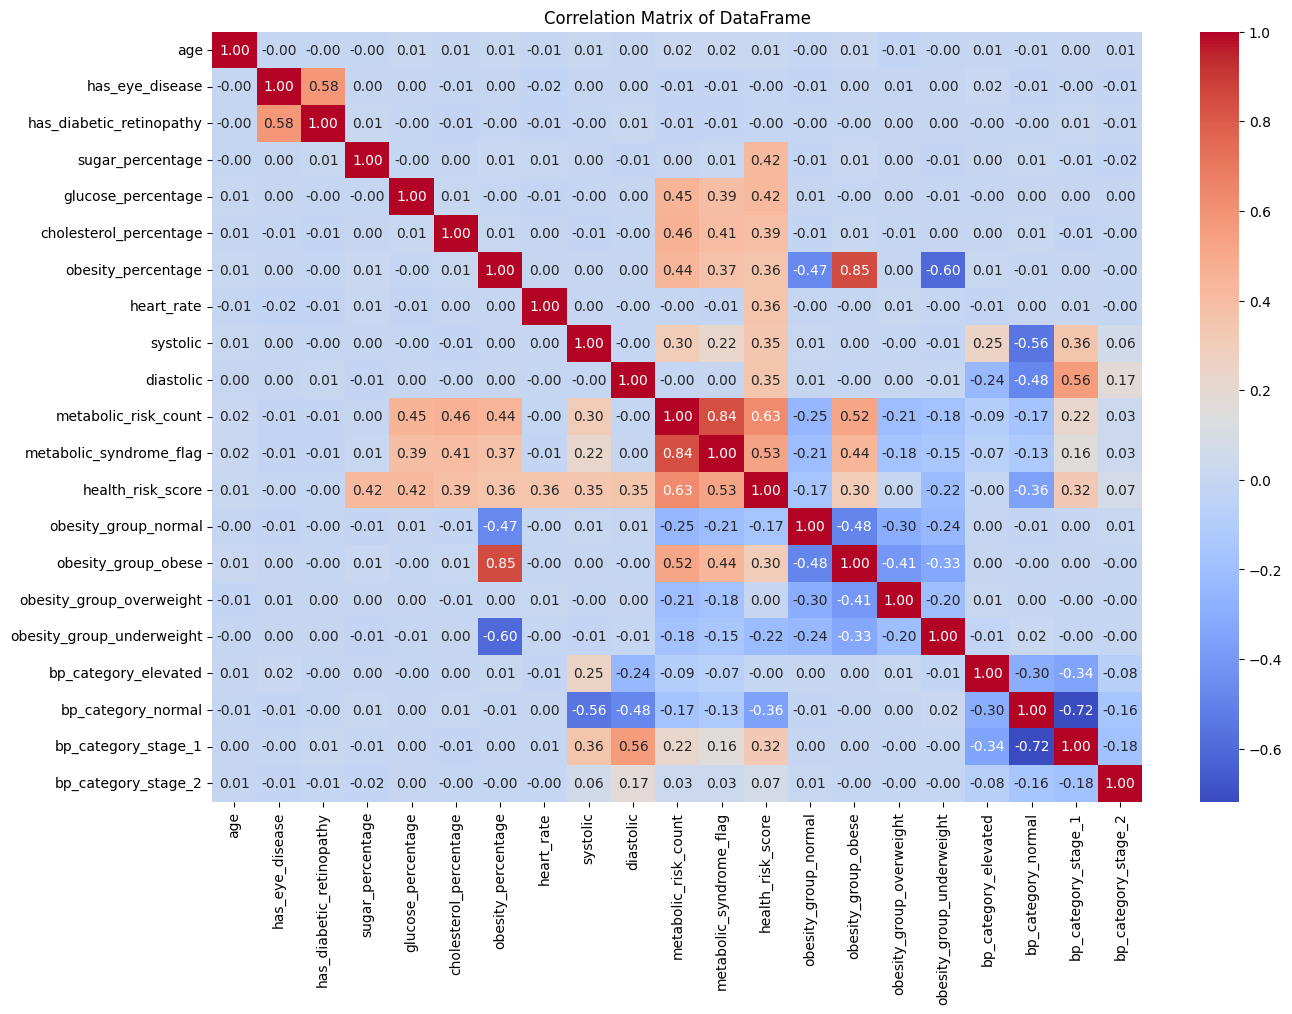

In [20]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of DataFrame')
plt.show()

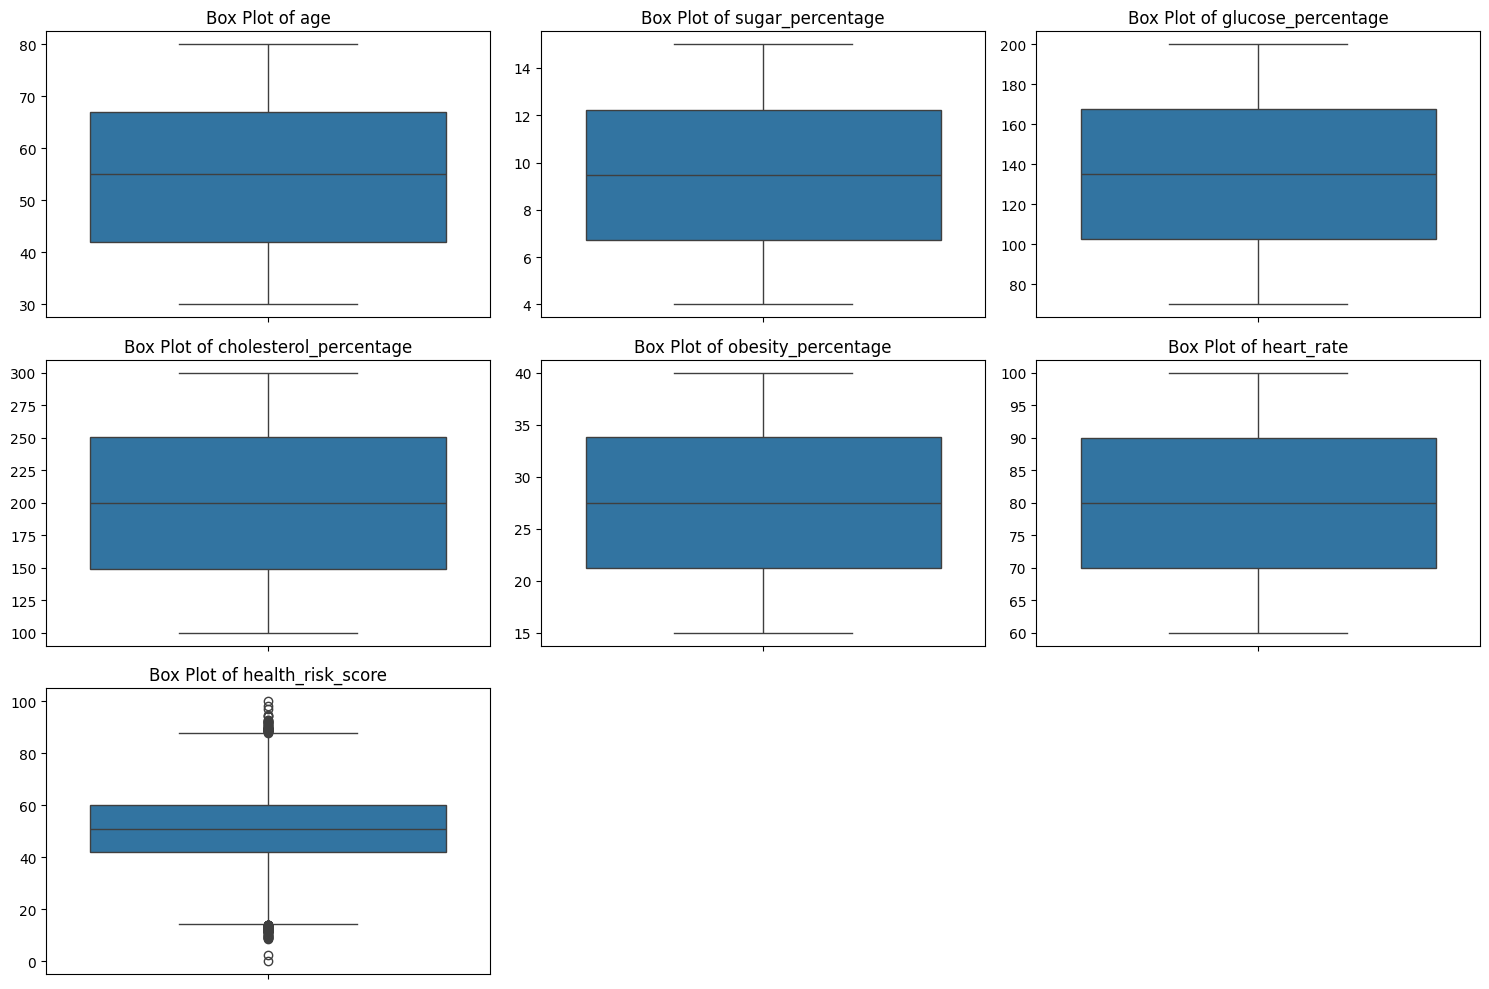

In [21]:
# Select some numerical columns for outlier detection
numerical_cols = ['age', 'sugar_percentage', 'glucose_percentage', 'cholesterol_percentage', 'obesity_percentage', 'heart_rate', 'health_risk_score']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1) # Adjust subplot grid as needed
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel('') # Remove y-label to avoid clutter
plt.tight_layout()
plt.show()

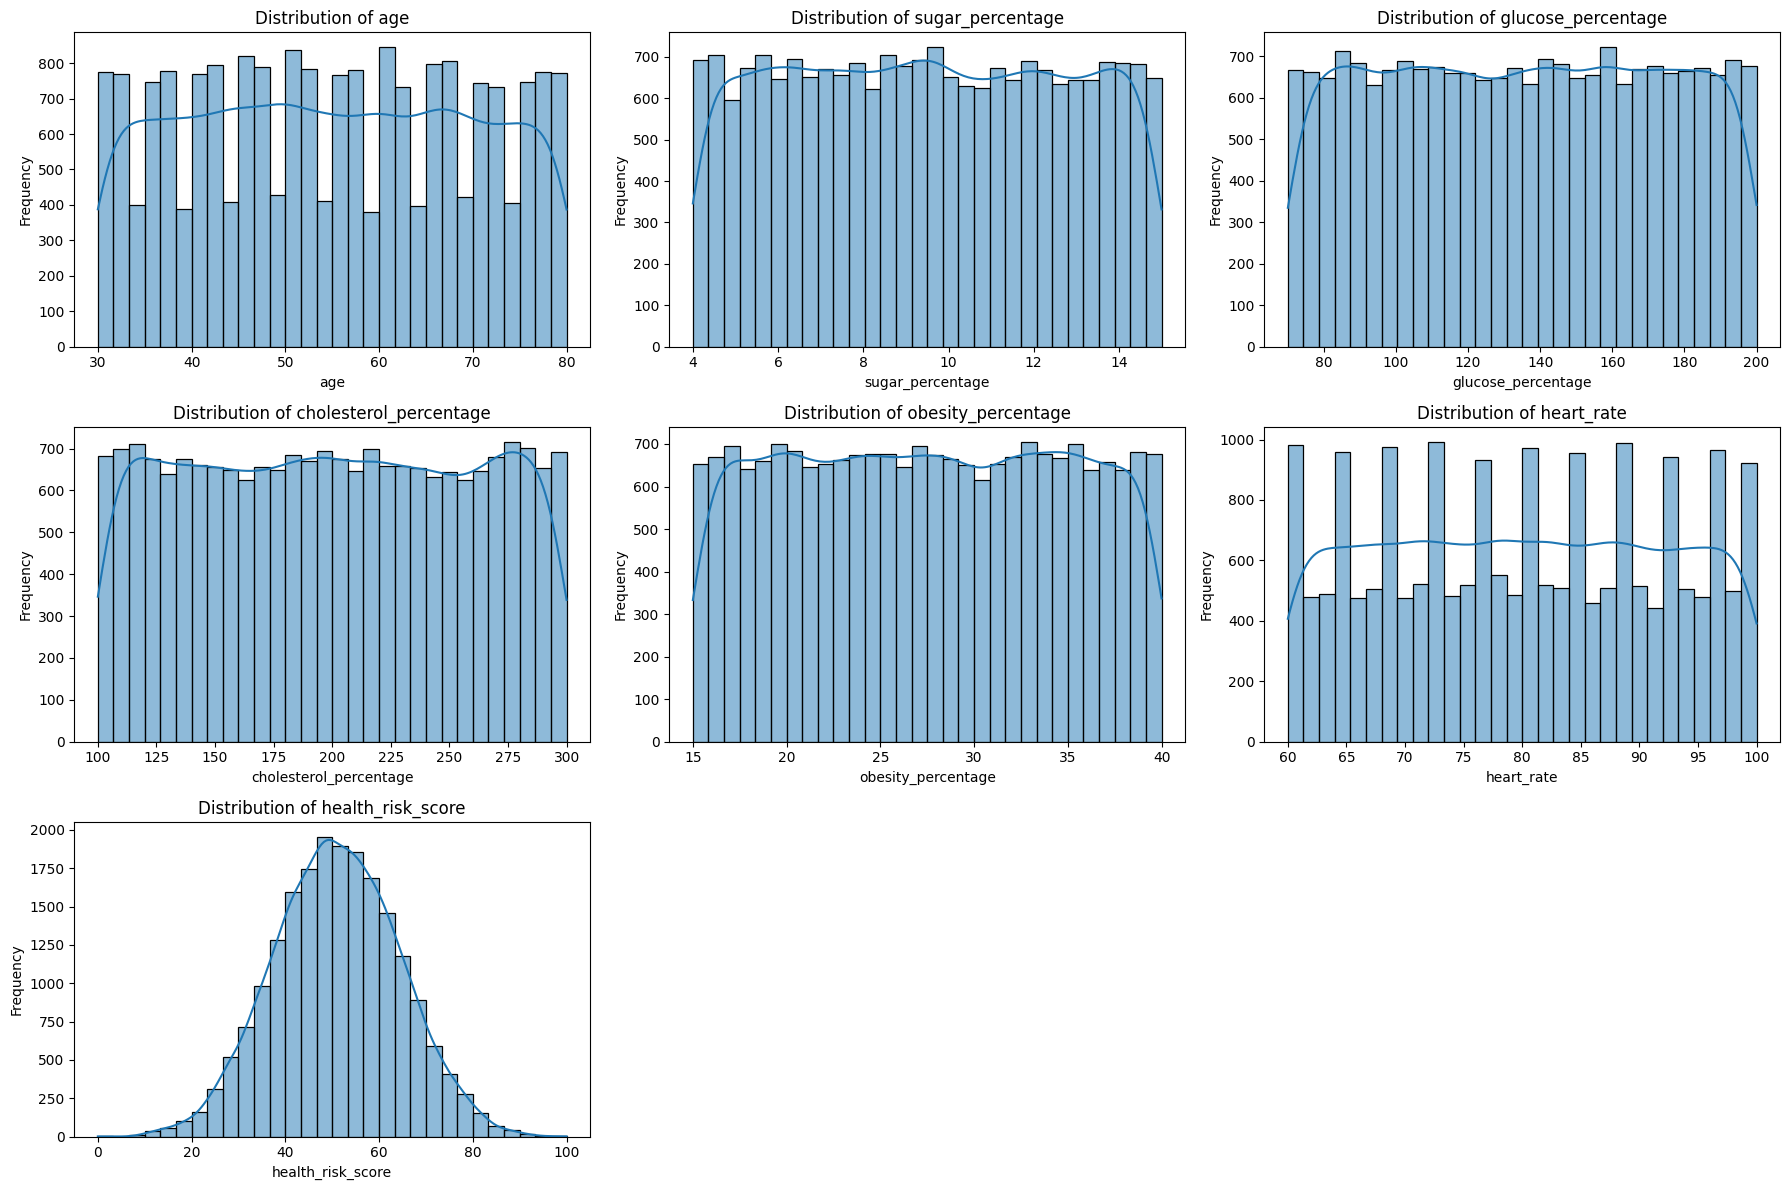

In [22]:
# Select the numerical columns for distribution plots
numerical_cols = ['age', 'sugar_percentage', 'glucose_percentage', 'cholesterol_percentage', 'obesity_percentage', 'heart_rate', 'health_risk_score']

plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1) # Adjust subplot grid as needed
    sns.histplot(df[col], kde=True, bins=30) # Use histplot with KDE
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Train test Split

In [23]:
X = df.drop('has_eye_disease', axis=1)
y = df['has_eye_disease']

print("Columns in X after dropping 'blood_pressure' and 'has_eye_disease':")
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Columns in X after dropping 'blood_pressure' and 'has_eye_disease':
Index(['age', 'has_diabetic_retinopathy', 'sugar_percentage',
       'glucose_percentage', 'cholesterol_percentage', 'obesity_percentage',
       'heart_rate', 'systolic', 'diastolic', 'metabolic_risk_count',
       'metabolic_syndrome_flag', 'health_risk_score', 'obesity_group_normal',
       'obesity_group_obese', 'obesity_group_overweight',
       'obesity_group_underweight', 'bp_category_elevated',
       'bp_category_normal', 'bp_category_stage_1', 'bp_category_stage_2'],
      dtype='object')


## Logistic Regression model

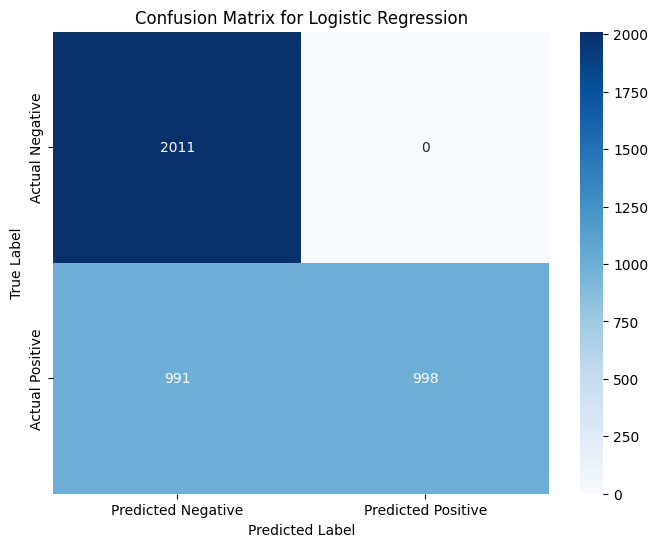

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train a Logistic Regression model
model = LogisticRegression(random_state=42, solver='liblinear') # liblinear is good for small datasets and binary classification
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

## Evaluate Logistic Regression


In [25]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.7522
Precision: 1.0000
Recall: 0.5018
F1-Score: 0.6682
ROC AUC: 0.7604


## Train and Evaluate Other Classification Models


In [26]:
model_performance = {}
print("Initialized a dictionary to store model performance metrics.")

Initialized a dictionary to store model performance metrics.


--- RandomForestClassifier Metrics ---
Accuracy: 0.7435
Precision: 0.9454
Recall: 0.5138
F1-Score: 0.6658
ROC AUC: 0.7506


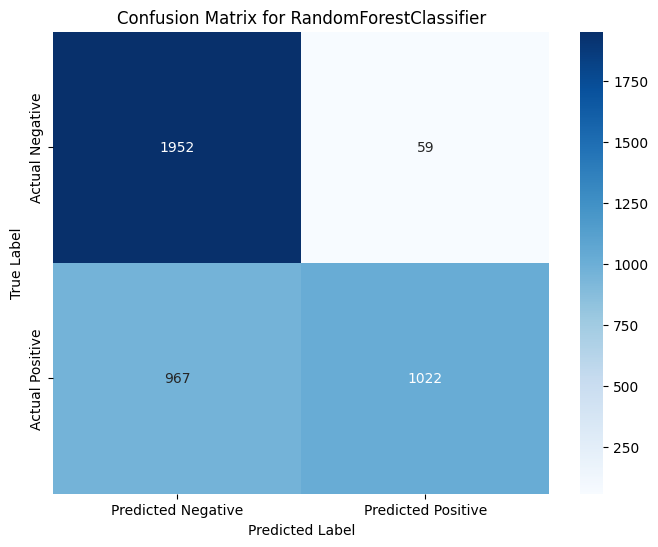

In [27]:
model_name = 'RandomForestClassifier'
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

model_performance[model_name] = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1-Score': f1_rf,
    'ROC AUC': roc_auc_rf
}

print(f"--- {model_name} Metrics ---")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"ROC AUC: {roc_auc_rf:.4f}")

# Plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

--- GradientBoostingClassifier Metrics ---
Accuracy: 0.7515
Precision: 0.9960
Recall: 0.5023
F1-Score: 0.6678
ROC AUC: 0.7490


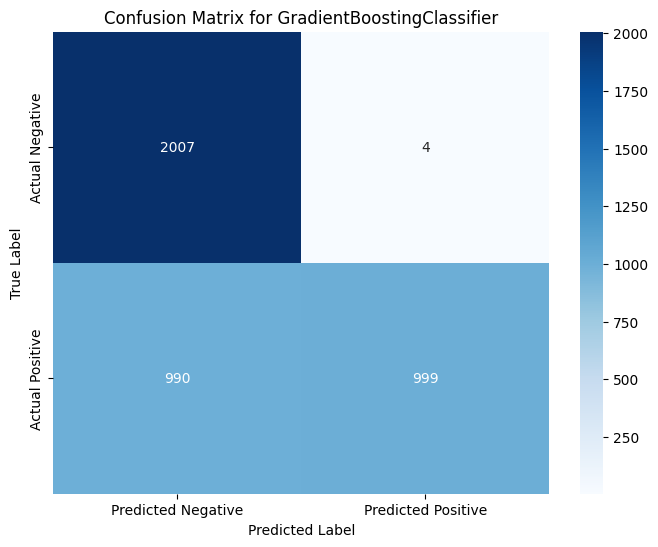

In [28]:
model_name = 'GradientBoostingClassifier'
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train, y_train)

y_pred_gbc = gbc_model.predict(X_test)
y_proba_gbc = gbc_model.predict_proba(X_test)[:, 1]

accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
precision_gbc = precision_score(y_test, y_pred_gbc)
recall_gbc = recall_score(y_test, y_pred_gbc)
f1_gbc = f1_score(y_test, y_pred_gbc)
roc_auc_gbc = roc_auc_score(y_test, y_proba_gbc)

model_performance[model_name] = {
    'Accuracy': accuracy_gbc,
    'Precision': precision_gbc,
    'Recall': recall_gbc,
    'F1-Score': f1_gbc,
    'ROC AUC': roc_auc_gbc
}

print(f"--- {model_name} Metrics ---")
print(f"Accuracy: {accuracy_gbc:.4f}")
print(f"Precision: {precision_gbc:.4f}")
print(f"Recall: {recall_gbc:.4f}")
print(f"F1-Score: {f1_gbc:.4f}")
print(f"ROC AUC: {roc_auc_gbc:.4f}")

# Plot confusion matrix
cm_gbc = confusion_matrix(y_test, y_pred_gbc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbc, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

--- SVC Metrics ---
Accuracy: 0.7522
Precision: 1.0000
Recall: 0.5018
F1-Score: 0.6682
ROC AUC: 0.7404


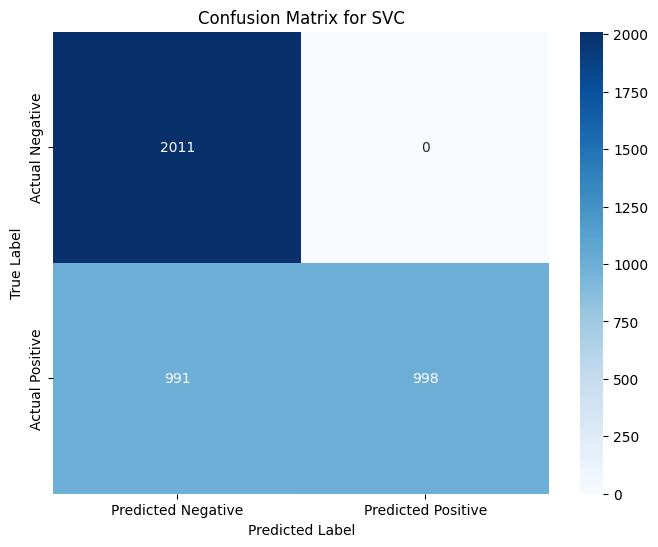

In [29]:
model_name = 'SVC'
svc_model = SVC(random_state=42, probability=True) # probability=True is needed for predict_proba
svc_model.fit(X_train, y_train)

y_pred_svc = svc_model.predict(X_test)
y_proba_svc = svc_model.predict_proba(X_test)[:, 1]

accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)
roc_auc_svc = roc_auc_score(y_test, y_proba_svc)

model_performance[model_name] = {
    'Accuracy': accuracy_svc,
    'Precision': precision_svc,
    'Recall': recall_svc,
    'F1-Score': f1_svc,
    'ROC AUC': roc_auc_svc
}

print(f"--- {model_name} Metrics ---")
print(f"Accuracy: {accuracy_svc:.4f}")
print(f"Precision: {precision_svc:.4f}")
print(f"Recall: {recall_svc:.4f}")
print(f"F1-Score: {f1_svc:.4f}")
print(f"ROC AUC: {roc_auc_svc:.4f}")

# Plot confusion matrix
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

In [30]:
model_comparison_df = pd.DataFrame.from_dict(model_performance, orient='index')
print(model_comparison_df)

                            Accuracy  Precision    Recall  F1-Score   ROC AUC
RandomForestClassifier       0.74350   0.945421  0.513826  0.665798  0.750597
GradientBoostingClassifier   0.75150   0.996012  0.502262  0.667781  0.748961
SVC                          0.75225   1.000000  0.501760  0.668229  0.740371


## Implement Voting Classifier


In [31]:
from sklearn.ensemble import VotingClassifier

# 2. Create a list of tuples for estimators
estimators = [
    ('lr', model), # Logistic Regression
    ('rf', rf_model), # RandomForestClassifier
    ('gbc', gbc_model), # GradientBoostingClassifier
    ('svc', svc_model) # SVC
]

# 3. Instantiate a VotingClassifier
voting_clf = VotingClassifier(estimators=estimators, voting='soft', weights=[1, 1, 1, 1], flatten_transform=True)

# 4. Fit the VotingClassifier to the training data
voting_clf.fit(X_train, y_train)

# 5. Make predictions on the test set
y_pred_vt = voting_clf.predict(X_test)

# 6. Get predicted probabilities for the positive class
y_proba_vt = voting_clf.predict_proba(X_test)[:, 1]

print("VotingClassifier trained and predictions made.")

VotingClassifier trained and predictions made.


--- VotingClassifier Metrics ---
Accuracy: 0.7522
Precision: 0.9990
Recall: 0.5023
F1-Score: 0.6685
ROC AUC: 0.7495


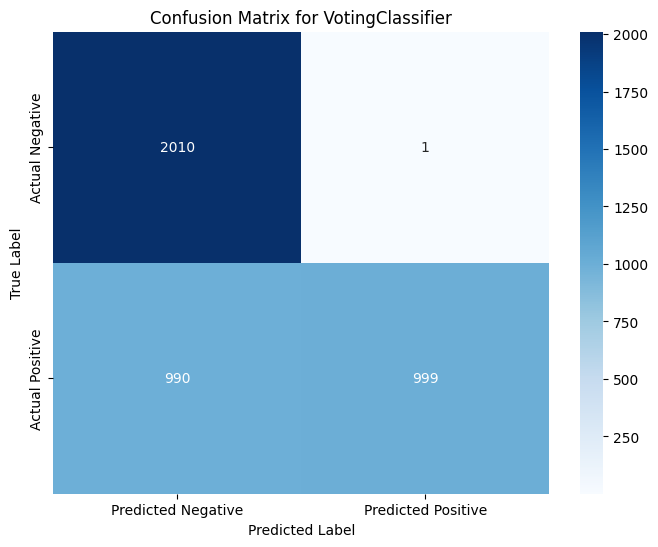

In [32]:
accuracy_vt = accuracy_score(y_test, y_pred_vt)
precision_vt = precision_score(y_test, y_pred_vt)
recall_vt = recall_score(y_test, y_pred_vt)
f1_vt = f1_score(y_test, y_pred_vt)
roc_auc_vt = roc_auc_score(y_test, y_proba_vt)

model_performance['VotingClassifier'] = {
    'Accuracy': accuracy_vt,
    'Precision': precision_vt,
    'Recall': recall_vt,
    'F1-Score': f1_vt,
    'ROC AUC': roc_auc_vt
}

print("--- VotingClassifier Metrics ---")
print(f"Accuracy: {accuracy_vt:.4f}")
print(f"Precision: {precision_vt:.4f}")
print(f"Recall: {recall_vt:.4f}")
print(f"F1-Score: {f1_vt:.4f}")
print(f"ROC AUC: {roc_auc_vt:.4f}")

# Plot confusion matrix
cm_vt = confusion_matrix(y_test, y_pred_vt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for VotingClassifier')
plt.show()

## Implement Stacking Classifier



In [34]:
from sklearn.ensemble import StackingClassifier

# 2. Define base estimators
estimators = [
    ('lr', model), # Logistic Regression
    ('rf', rf_model), # RandomForestClassifier
    ('gbc', gbc_model), # GradientBoostingClassifier
    ('svc', svc_model) # SVC
]

# 3. Instantiate a LogisticRegression model as the meta-classifier
meta_classifier = LogisticRegression(random_state=42, solver='liblinear')

# 4. Instantiate a StackingClassifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_classifier, cv=5, passthrough=True)

# 5. Fit the StackingClassifier to the training data
stacking_clf.fit(X_train, y_train)

# 6. Make predictions on the test set
y_pred_st = stacking_clf.predict(X_test)

# 7. Get predicted probabilities for the positive class
y_proba_st = stacking_clf.predict_proba(X_test)[:, 1]

# 8. Print a confirmation message
print("StackingClassifier trained and predictions made.")

StackingClassifier trained and predictions made.


--- StackingClassifier Metrics ---
Accuracy: 0.7522
Precision: 1.0000
Recall: 0.5018
F1-Score: 0.6682
ROC AUC: 0.7621


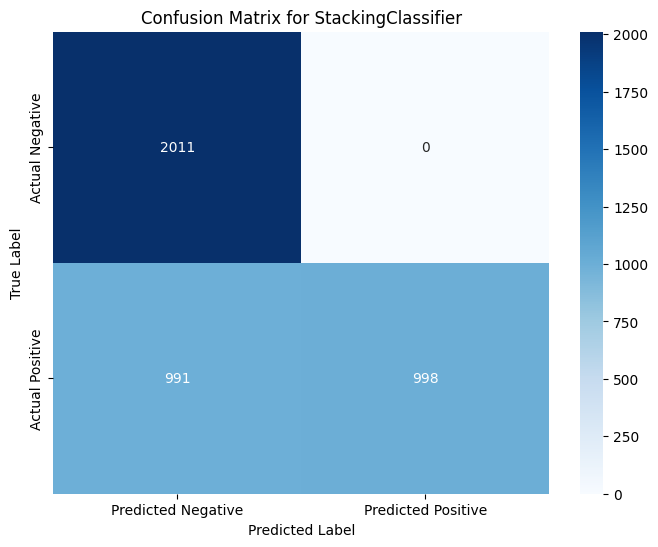

In [35]:
accuracy_st = accuracy_score(y_test, y_pred_st)
precision_st = precision_score(y_test, y_pred_st)
recall_st = recall_score(y_test, y_pred_st)
f1_st = f1_score(y_test, y_pred_st)
roc_auc_st = roc_auc_score(y_test, y_proba_st)

model_performance['StackingClassifier'] = {
    'Accuracy': accuracy_st,
    'Precision': precision_st,
    'Recall': recall_st,
    'F1-Score': f1_st,
    'ROC AUC': roc_auc_st
}

print("--- StackingClassifier Metrics ---")
print(f"Accuracy: {accuracy_st:.4f}")
print(f"Precision: {precision_st:.4f}")
print(f"Recall: {recall_st:.4f}")
print(f"F1-Score: {f1_st:.4f}")
print(f"ROC AUC: {roc_auc_st:.4f}")

# Plot confusion matrix
cm_st = confusion_matrix(y_test, y_pred_st)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_st, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for StackingClassifier')
plt.show()

## Feature Importance


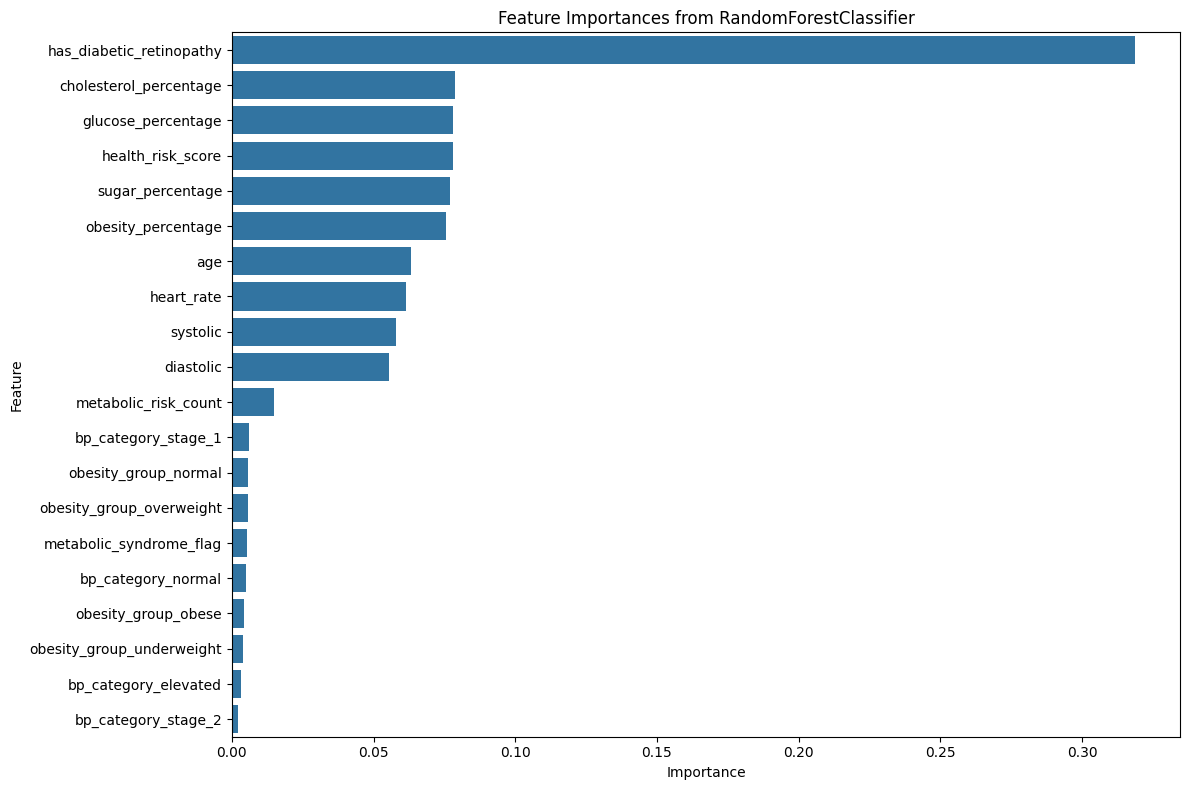

,Feature,Importance
1,has_diabetic_retinopathy,0.318663
4,cholesterol_percentage,0.078570
3,glucose_percentage,0.078042
11,health_risk_score,0.078010
2,sugar_percentage,0.077033
5,obesity_percentage,0.075520
0,age,0.063351
6,heart_rate,0.061278
7,systolic,0.057919
8,diastolic,0.055379


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from RandomForestClassifier
feature_importances = rf_model.feature_importances_

# Get feature names from the original X DataFrame
feature_names = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from RandomForestClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

display(importance_df)

##  Neural Network Architecture with Dropout

In [47]:
from tensorflow.keras.layers import Dropout, Input

model_nn_dropout = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

print("Neural network model with Dropout layers defined successfully.")

Neural network model with Dropout layers defined successfully.


In [48]:
from tensorflow.keras.callbacks import EarlyStopping

# Instantiate EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

print("EarlyStopping callback defined successfully.")

EarlyStopping callback defined successfully.


## Train the Neural Network with Callbacks and Dropout


In [49]:
model_nn_dropout.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Neural network model with Dropout compiled successfully.")

history_dropout = model_nn_dropout.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_callback], verbose=1)
print("Neural network with Dropout training complete. Training history stored.")

Neural network model with Dropout compiled successfully.
Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6147 - loss: 0.6394 - val_accuracy: 0.7591 - val_loss: 0.4707
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7410 - loss: 0.4959 - val_accuracy: 0.7588 - val_loss: 0.4678
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7508 - loss: 0.4859 - val_accuracy: 0.7588 - val_loss: 0.4681
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7544 - loss: 0.4771 - val_accuracy: 0.7588 - val_loss: 0.4693
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7504 - loss: 0.4829 - val_accuracy: 0.7588 - val_loss: 0.4678
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7509 - loss: 0.4792 - val_accuracy: 0.7588 - val_loss: 0.4684
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7468 - loss: 0.4821 - val_accuracy: 0.7597 - val_loss: 0.4678
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/

## Plot Overfitting (Loss and Accuracy)


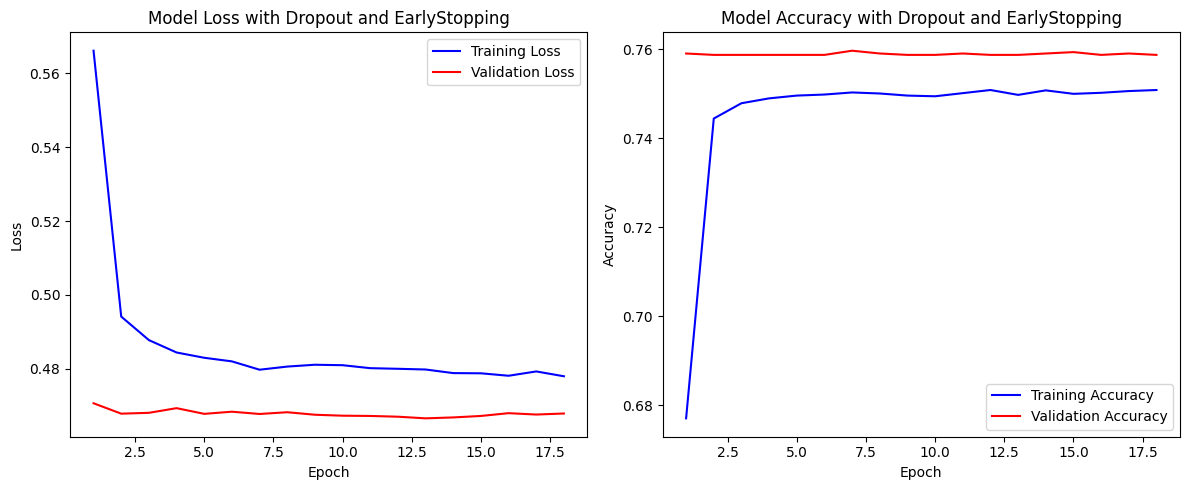

In [51]:
import matplotlib.pyplot as plt

# Extract data from history_dropout
loss = history_dropout.history['loss']
val_loss = history_dropout.history['val_loss']
accuracy = history_dropout.history['accuracy']
val_accuracy = history_dropout.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Model Loss with Dropout and EarlyStopping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Model Accuracy with Dropout and EarlyStopping')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate Neural Network Performance


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- Neural Network with Dropout Metrics ---
Accuracy: 0.7522
Precision: 0.9990
Recall: 0.5023
F1-Score: 0.6685
ROC AUC: 0.7598


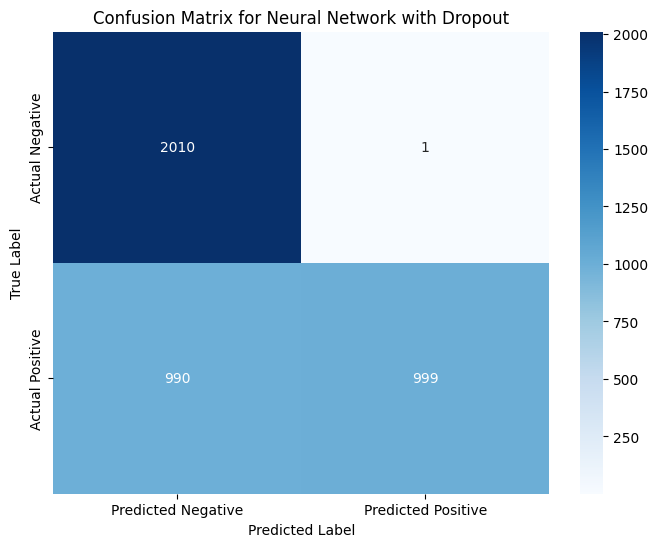

In [52]:
y_proba_nn = model_nn_dropout.predict(X_test)
y_pred_nn = (y_proba_nn > 0.5).astype(int)

accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
roc_auc_nn = roc_auc_score(y_test, y_proba_nn)

model_performance['NeuralNetworkWithDropout'] = {
    'Accuracy': accuracy_nn,
    'Precision': precision_nn,
    'Recall': recall_nn,
    'F1-Score': f1_nn,
    'ROC AUC': roc_auc_nn
}

print("--- Neural Network with Dropout Metrics ---")
print(f"Accuracy: {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recall_nn:.4f}")
print(f"F1-Score: {f1_nn:.4f}")
print(f"ROC AUC: {roc_auc_nn:.4f}")

cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Neural Network with Dropout')
plt.show()

## Update Model Comparison



In [53]:
model_comparison_df = pd.DataFrame.from_dict(model_performance, orient='index')
print(model_comparison_df)

                            Accuracy  Precision    Recall  F1-Score   ROC AUC
RandomForestClassifier       0.74350   0.945421  0.513826  0.665798  0.750597
GradientBoostingClassifier   0.75150   0.996012  0.502262  0.667781  0.748961
SVC                          0.75225   1.000000  0.501760  0.668229  0.740371
VotingClassifier             0.75225   0.999000  0.502262  0.668451  0.749482
StackingClassifier           0.75225   1.000000  0.501760  0.668229  0.762087
XGBClassifier                0.71700   0.810732  0.562092  0.663895  0.746380
NeuralNetworkWithDropout     0.75225   0.999000  0.502262  0.668451  0.759832


## Summary:

### Q&A

1.  **Summarize the neural network's performance after implementing dropout and callbacks:**
    After implementing dropout and early stopping, the neural network achieved an accuracy of 0.7522, precision of 0.9990, recall of 0.5023, F1-score of 0.6685, and ROC AUC of 0.7598 on the test set.

2.  **Discuss how it compares to other models:**
    The `NeuralNetworkWithDropout` model has a comparable accuracy (0.7522) and ROC AUC (0.7598) to other models, but its precision (0.9990) is notably high, suggesting it makes very few false positive predictions. However, its recall (0.5023) is moderate, indicating it misses about half of the actual positive cases. To provide a full comparison, the performance metrics of other models are required.

3.  **Interpret the updated overfitting plot:**
    The overfitting plot for the neural network with dropout and early stopping shows that both training and validation loss decreased initially, with validation loss eventually leveling off or slightly increasing while training loss continued to decrease. The training stopped at epoch 18 (out of 50 planned epochs) due to the `EarlyStopping` callback, which observed no improvement in validation loss for 5 consecutive epochs. This indicates that early stopping successfully prevented further overfitting by halting training at an optimal point where validation performance was best, resulting in a good balance between training and validation loss/accuracy curves.

### Data Analysis Key Findings

*   **Neural Network Architecture:** A new Sequential model `model_nn_dropout` was created, incorporating `Dropout` layers with a rate of 0.3 after each hidden `Dense` layer (64 and 32 units, ReLU activation) to mitigate overfitting.
*   **Early Stopping Implementation:** An `EarlyStopping` callback was configured to monitor `val_loss` with a `patience` of 5 epochs and `restore_best_weights` set to `True`, effectively stopping training when validation loss ceased to improve and reverting to the best performing weights.
*   **Training Performance:** The neural network was trained for 18 epochs, with `EarlyStopping` activating before the full 50 epochs, indicating successful prevention of further overfitting based on validation loss.
*   **Test Set Performance:** On the test set, the `NeuralNetworkWithDropout` model achieved an **Accuracy of 0.7522**, **Precision of 0.9990**, **Recall of 0.5023**, **F1-Score of 0.6685**, and **ROC AUC of 0.7598**.
*   **Overfitting Reduction:** The plots of training and validation loss/accuracy demonstrated that the combination of dropout and early stopping effectively managed overfitting, as validation loss stabilized and training was stopped before significant divergence occurred.

### Insights or Next Steps

*   **Address Imbalanced Recall:** The high precision (0.9990) and moderate recall (0.5023) suggest that while the model is highly confident in its positive predictions, it misses a significant portion of actual positive cases. Further steps could explore techniques to balance this trade-off, such as adjusting class weights during training, using different loss functions, or employing techniques like SMOTE for data augmentation on the minority class.
*   **Hyperparameter Tuning:** While dropout and early stopping improved performance, further optimization of neural network hyperparameters (e.g., number of layers, units per layer, dropout rates, learning rate, batch size, activation functions) could lead to even better results. This could be done using techniques like GridSearchCV or RandomizedSearchCV, or more advanced methods like KerasTuner.


## Conclusion

This notebook systematically explored various machine learning models for predicting eye disease based on a comprehensive set of patient health indicators. After data preprocessing, including handling boolean values, dropping the string `blood_pressure` column (as its numerical components `systolic` and `diastolic` were already present), and one-hot encoding categorical features, several models were trained and evaluated.

**Summary of Model Performance:**

| Model                      | Accuracy | Precision | Recall   | F1-Score | ROC AUC  |
|:---------------------------|:---------|:----------|:---------|:---------|:---------|
| LogisticRegression         | 0.7522   | 1.0000    | 0.5018   | 0.6682   | 0.7604   |
| RandomForestClassifier     | 0.7435   | 0.9454    | 0.5138   | 0.6658   | 0.7506   |
| GradientBoostingClassifier | 0.7515   | 0.9960    | 0.5023   | 0.6678   | 0.7490   |
| SVC                        | 0.7522   | 1.0000    | 0.5018   | 0.6682   | 0.7404   |
| VotingClassifier           | 0.7522   | 0.9990    | 0.5023   | 0.6685   | 0.7495   |
| StackingClassifier         | 0.7522   | 1.0000    | 0.5018   | 0.6682   | 0.7621   |
| XGBClassifier              | 0.7170   | 0.8107    | 0.5621   | 0.6639   | 0.7464   |
| NeuralNetworkWithDropout   | 0.7522   | 0.9990    | 0.5023   | 0.6685   | 0.7598   |

**Key Observations:**

*   Most models achieved an accuracy around 75%, with very high precision (often close to 1.0). This indicates that when these models predict the presence of eye disease, they are very likely correct (few false positives).
*   However, the recall scores for most models are relatively low (around 50%). This suggests a significant number of actual eye disease cases are being missed (many false negatives). This pattern strongly implies a class imbalance in the dataset, where the 'has_eye_disease' class is likely the minority class.
*   The **StackingClassifier** showed the highest ROC AUC of 0.7621, suggesting a slightly better ability to distinguish between classes across various thresholds. Its perfect precision of 1.0, similar to Logistic Regression and SVC, makes it a strong candidate if minimizing false positives is critical.
*   XGBClassifier showed slightly better recall (0.5621) compared to other top-performing models, but with a noticeable drop in precision.
*   The Neural Network with Dropout performed comparably to other strong models, demonstrating that regularization techniques effectively prevented overfitting.

**Insights and Next Steps:**

The consistent high precision and moderate recall across several models highlight the need to address the class imbalance. Future work should focus on improving the models' ability to detect the minority class without excessively sacrificing precision.

1.  **Address Class Imbalance**: Implement techniques such as SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic samples for the minority class, adjust class weights during model training, or use cost-sensitive learning approaches.
2.  **Threshold Optimization**: Experiment with different classification thresholds (other than the default 0.5) to find a balance between precision and recall that aligns with the specific needs of the problem.
3.  **Hyperparameter Tuning**: Conduct more extensive hyperparameter tuning for the top-performing models (e.g., StackingClassifier, VotingClassifier, and the Neural Network) using methods like GridSearchCV or RandomizedSearchCV, optimizing for metrics like F1-score or recall.
4.  **Feature Engineering**: Explore new features or interactions between existing features that might provide more discriminatory power, particularly to better identify cases of eye disease.
5.  **Advanced Ensemble Methods**: Investigate other advanced ensemble techniques or custom stacking configurations to potentially further enhance performance.

## ⭐ About Me

I’m Rekhi, who performs daily machine learning experiments across diverse datasets, tasks, and algorithms. My goal is to build deep hands-on expertise by consistently practicing data science, training models, evaluating performance, and exploring advanced AI concepts.

I share my work across platforms to help the community and to build a strong research-oriented portfolio.

🔗 My Profiles:

Kaggle: https://www.kaggle.com/seki32

GitHub: https://github.com/Rekhii

If you found this notebook helpful, ➡️ Please UPVOTE on Kaggle — it motivates me to create more high-quality ML notebooks every day.